In [217]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import warnings
warnings.simplefilter('ignore')
from prophet import Prophet

In [218]:
#read the data
df = pd.read_csv("DailyDataFinal.csv", parse_dates=['date'], delimiter=',')

In [219]:
#check the dtypes
print(df.dtypes)

campaign name                           object
date                            datetime64[ns]
clicks                                   int64
impressions                              int64
cost_micros                              int64
bidding_strategy_type                   object
conversions                            float64
cost_per_conversion                    float64
Click-through rate (CTR)               float64
average cost per click (CPC)           float64
cost-per-acquisition (CPA)             float64
Cost                                   float64
conversion_per_euro                    float64
budget                                   int64
isholiday                                int64
dtype: object


In [220]:
df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y %H.%M.%S')

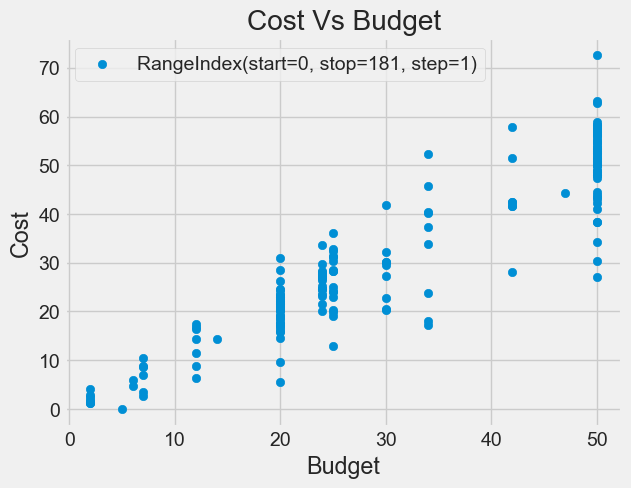

In [221]:
plt.scatter(df['budget'],df['Cost'],label=df.index)
# for i, name in enumerate(df.index):
#     plt.annotate(name, (df.budget[i], df.Cost[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize plot (add labels, title, etc.)
plt.xlabel('Budget')
plt.ylabel('Cost')
plt.title('Cost Vs Budget')
plt.legend()
plt.grid(True)
plt.show()

In [222]:
df.head(3)

,campaign name,date,clicks,impressions,cost_micros,bidding_strategy_type,conversions,cost_per_conversion,Click-through rate (CTR),average cost per click (CPC),cost-per-acquisition (CPA),Cost,conversion_per_euro,budget,isholiday
0,SHOPTIMISED PMax-46 - all products-M,2023-11-28,0,33,0,MAXIMIZE_CONVERSION_VALUE,0.0,NaN,0.000000,0.000000,0.000000,0.00,0.000000,5,0
1,SHOPTIMISED PMax-46 - all products-M,2023-11-29,11,1139,4060000,MAXIMIZE_CONVERSION_VALUE,1.0,4060000.0,0.965759,0.369091,4.060000,4.06,0.246305,2,0
2,SHOPTIMISED PMax-46 - all products-M,2023-11-30,7,655,1430000,MAXIMIZE_CONVERSION_VALUE,0.0,NaN,1.068702,0.204286,4.085714,1.43,0.000000,2,0


In [223]:
df.drop(['campaign name','clicks','impressions','cost_micros','bidding_strategy_type','cost_per_conversion','Click-through rate (CTR)','average cost per click (CPC)','cost-per-acquisition (CPA)','conversion_per_euro','Cost'],axis=1, inplace=True)

In [224]:
df.head(5)

,date,conversions,budget,isholiday
0,2023-11-28,0.000000,5,0
1,2023-11-29,1.000000,2,0
2,2023-11-30,0.000000,2,0
3,2023-12-01,0.000000,7,0
4,2023-12-02,3.332276,7,0


In [225]:
df.date.dt.year

0      2023
1      2023
2      2023
3      2023
4      2023
       ... 
176    2024
177    2024
178    2024
179    2024
180    2024
Name: date, Length: 181, dtype: int32

In [226]:
df['year']=df.date.dt.year
df['month']=df.date.dt.month
df['day']=df.date.dt.day
df['week']=df.date.dt.dayofweek

In [227]:
df

,date,conversions,budget,isholiday,year,month,day,week
0,2023-11-28,0.000000,5,0,2023,11,28,1
1,2023-11-29,1.000000,2,0,2023,11,29,2
2,2023-11-30,0.000000,2,0,2023,11,30,3
3,2023-12-01,0.000000,7,0,2023,12,1,4
4,2023-12-02,3.332276,7,0,2023,12,2,5
...,...,...,...,...,...,...,...,...
176,2024-05-22,1.000000,20,0,2024,5,22,2
177,2024-05-23,2.000000,20,0,2024,5,23,3
178,2024-05-24,1.000000,20,0,2024,5,24,4
179,2024-05-25,0.998544,20,0,2024,5,25,5


In [228]:
def applyer(row):
    if row.dayofweek==5 or row.dayofweek==6:
        return 1
    else:
        return 0

In [229]:
df['isweekend']=df['date'].apply(applyer)
df

,date,conversions,budget,isholiday,year,month,day,week,isweekend
0,2023-11-28,0.000000,5,0,2023,11,28,1,0
1,2023-11-29,1.000000,2,0,2023,11,29,2,0
2,2023-11-30,0.000000,2,0,2023,11,30,3,0
3,2023-12-01,0.000000,7,0,2023,12,1,4,0
4,2023-12-02,3.332276,7,0,2023,12,2,5,1
...,...,...,...,...,...,...,...,...,...
176,2024-05-22,1.000000,20,0,2024,5,22,2,0
177,2024-05-23,2.000000,20,0,2024,5,23,3,0
178,2024-05-24,1.000000,20,0,2024,5,24,4,0
179,2024-05-25,0.998544,20,0,2024,5,25,5,1


## conversion

In [230]:
conv =df.rename(columns={'date': 'ds', 'conversions': 'y'})

In [231]:
#creating the train and validation set
train = conv[:int(0.8*(len(conv)))]
valid = conv[int(0.8*(len(conv))):]

In [232]:
train.dtypes

ds           datetime64[ns]
y                   float64
budget                int64
isholiday             int64
year                  int32
month                 int32
day                   int32
week                  int32
isweekend             int64
dtype: object

In [233]:
train.head(5)

,ds,y,budget,isholiday,year,month,day,week,isweekend
0,2023-11-28,0.000000,5,0,2023,11,28,1,0
1,2023-11-29,1.000000,2,0,2023,11,29,2,0
2,2023-11-30,0.000000,2,0,2023,11,30,3,0
3,2023-12-01,0.000000,7,0,2023,12,1,4,0
4,2023-12-02,3.332276,7,0,2023,12,2,5,1


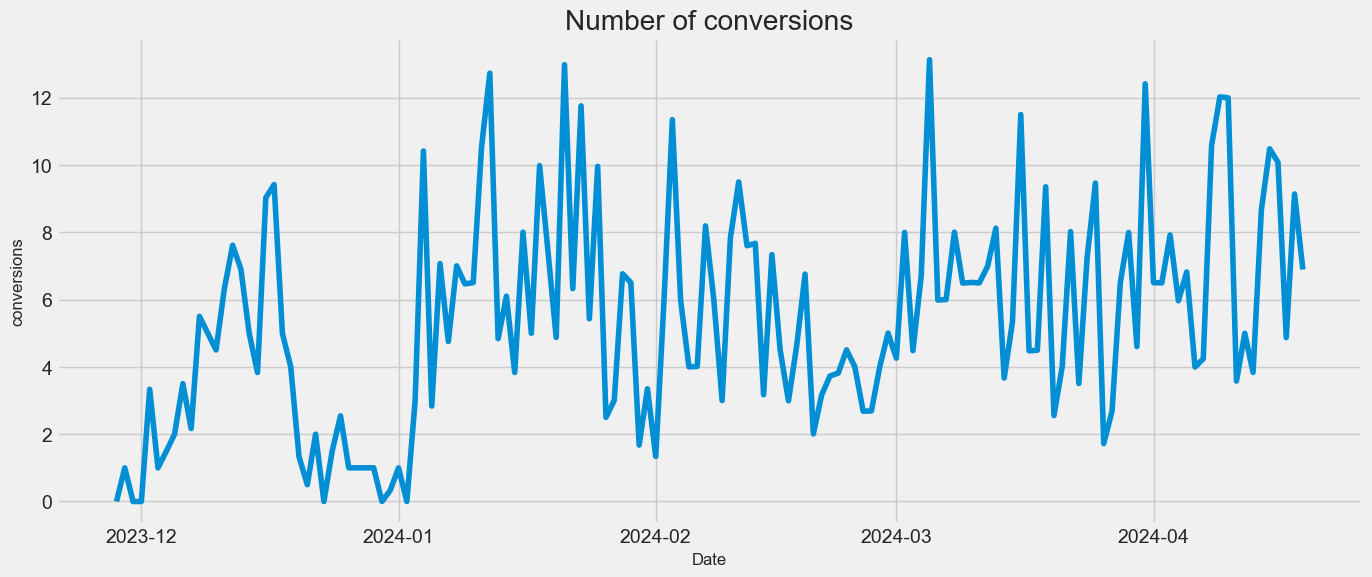

In [234]:
plt.figure(figsize = (15, 6))
plt.plot(train['ds'], train['y'])
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('conversions', {'fontsize': 12})
plt.title('Number of conversions')
plt.show()

In [235]:
from prophet.make_holidays import make_holidays_df

uk_holidays = make_holidays_df(
    year_list=[2023,2024], country='GB'
)
uk_holidays.head()

,ds,holiday
0,2024-03-29,Good Friday
1,2024-05-06,May Day
2,2024-05-27,Spring Bank Holiday
3,2024-01-01,New Year's Day
4,2024-12-25,Christmas Day


In [236]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 9 or date.month < 3)

train['on_season'] = train['ds'].apply(is_nfl_season)
train['off_season'] = ~train['ds'].apply(is_nfl_season)


In [237]:
def is_peak(ds):
    date = pd.to_datetime(ds)
    if (date.month > 9 or date.month < 3):
        return 1
    else:
        return 0

In [253]:
train['ispeak'] = train['ds'].apply(is_peak)
conv['ispeak'] = conv['ds'].apply(is_peak)

In [239]:
train

,ds,y,budget,isholiday,year,month,day,week,isweekend,on_season,off_season,ispeak
0,2023-11-28,0.000000,5,0,2023,11,28,1,0,True,False,1
1,2023-11-29,1.000000,2,0,2023,11,29,2,0,True,False,1
2,2023-11-30,0.000000,2,0,2023,11,30,3,0,True,False,1
3,2023-12-01,0.000000,7,0,2023,12,1,4,0,True,False,1
4,2023-12-02,3.332276,7,0,2023,12,2,5,1,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-04-15,10.476022,50,0,2024,4,15,0,0,False,True,0
140,2024-04-16,10.079527,50,0,2024,4,16,1,0,False,True,0
141,2024-04-17,4.868349,50,0,2024,4,17,2,0,False,True,0
142,2024-04-18,9.134768,50,0,2024,4,18,3,0,False,True,0


In [240]:
#fit the model
model = Prophet(holidays=uk_holidays,holidays_prior_scale=0.05)
model.add_regressor('budget')
model.add_country_holidays(country_name='GB')
# model.add_seasonality(name='monthly',period=30.5,fourier_order=5)
# model.add_seasonality(name='monthly_on_season',period=30.5,fourier_order=5,condition_name='on_season')
# model.add_seasonality(name='monthly_off_season',period=30.5,fourier_order=5,condition_name='off_season')
# model.add_seasonality(name='weekly_on_season',period=7,fourier_order=3,condition_name='on_season')
# model.add_seasonality(name='weekly_off_season',period=7,fourier_order=3,condition_name='off_season')
# model.add_seasonality(name='weekly',period=7,fourier_order=3,prior_scale=0.1)

# model.add_regressor('isholiday')
model.add_regressor('year')
model.add_regressor('month')
model.add_regressor('day')
model.add_regressor('week')
model.add_regressor('isweekend')
model.add_regressor('ispeak')
model.fit(train)

17:26:54 - cmdstanpy - INFO - Chain [1] start processing
17:26:54 - cmdstanpy - INFO - Chain [1] done processing


In [241]:
valid['on_season'] = valid['ds'].apply(is_nfl_season)
valid['off_season'] = ~valid['ds'].apply(is_nfl_season)
valid['ispeak'] = valid['ds'].apply(is_peak)
valid_predict=model.predict(valid.drop('y',axis=1))

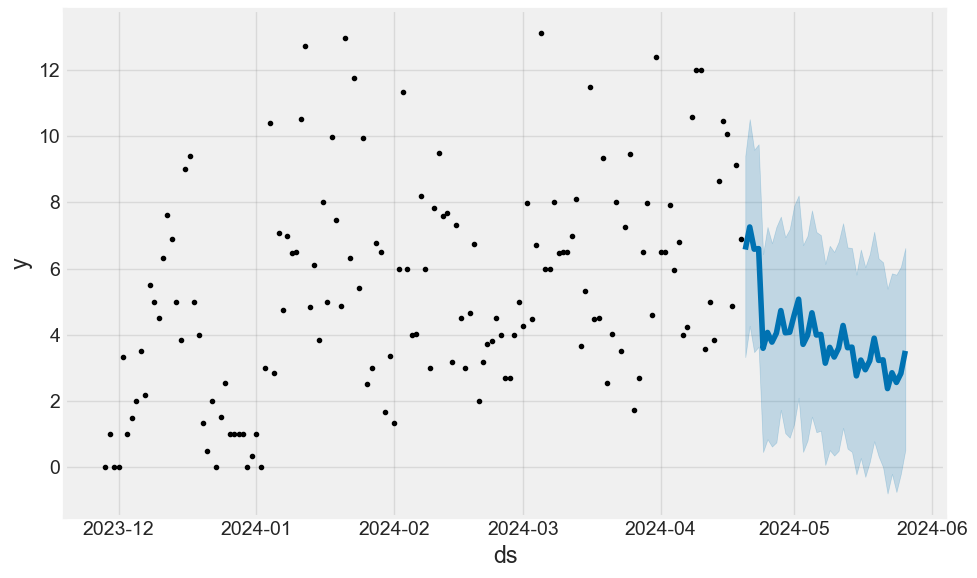

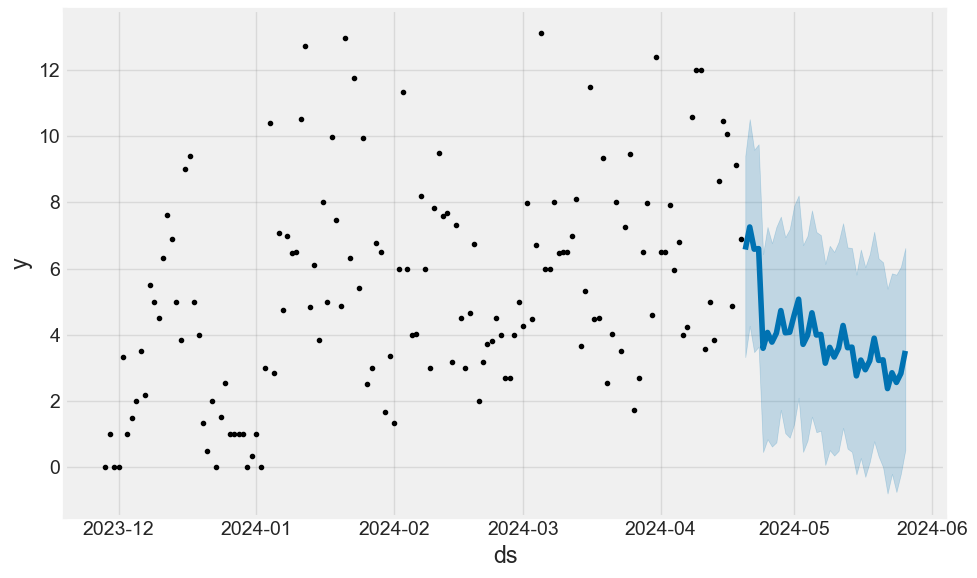

In [242]:
model.plot(valid_predict)

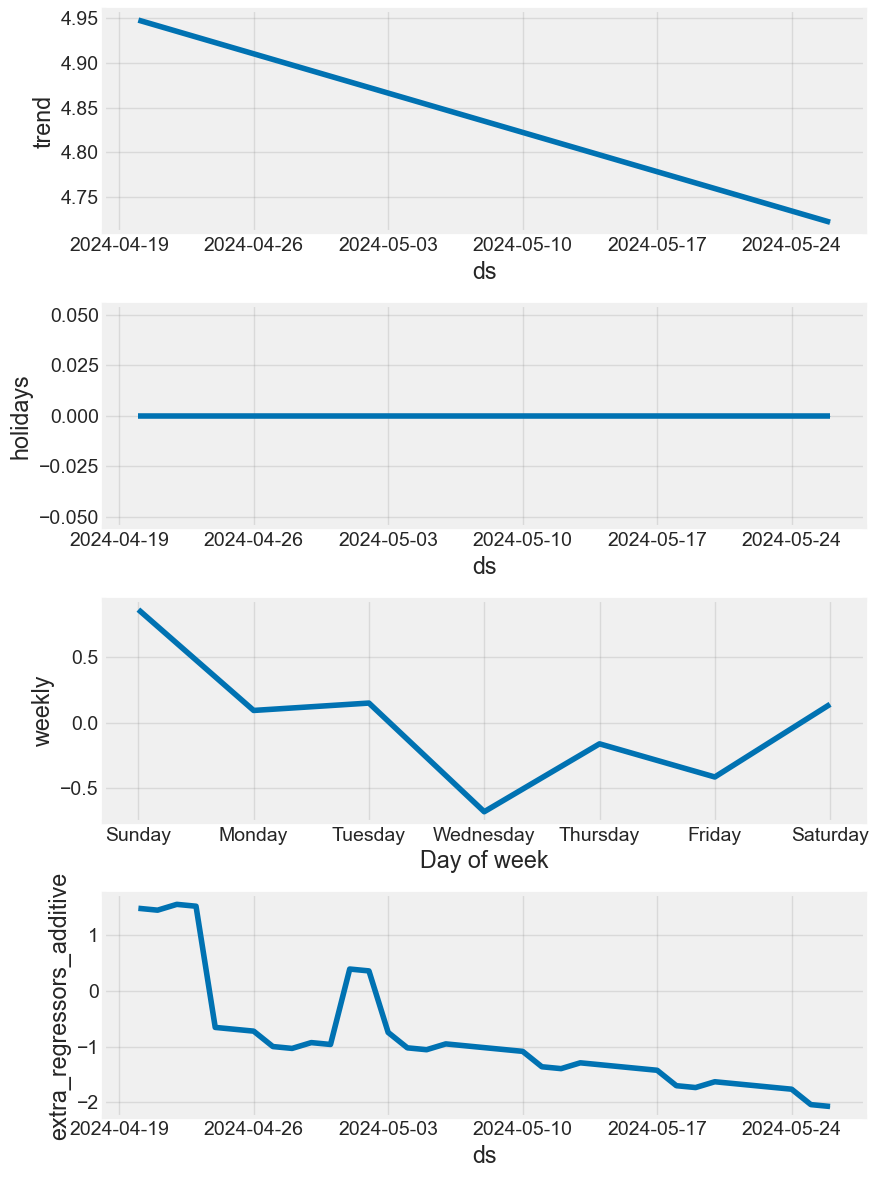

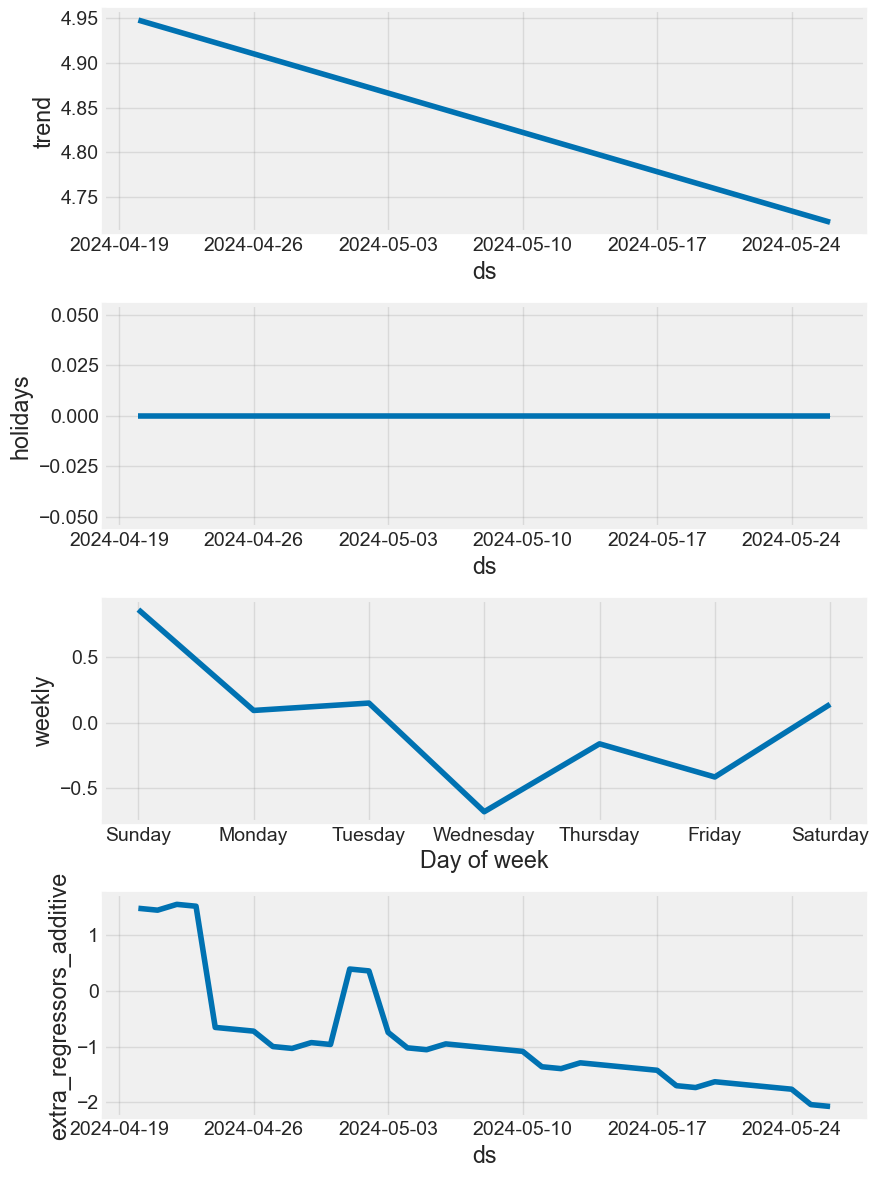

In [243]:
model.plot_components(valid_predict)

In [244]:
# from prophet.plot import plot_yearly
# a = plot_yearly(model)

In [245]:
predicted=pd.DataFrame()
predicted['date']=valid_predict.ds
predicted['conversions']=valid_predict.yhat
predicted['budget']=valid_predict.budget
# predicted['isholiday']=valid_predict.isholiday
# predicted['year']=valid_predict.year
# predicted['month']=valid_predict.month
# predicted['day']=valid_predict.day
# predicted['week']=valid_predict.week
# predicted['isweekend']=valid_predict.isweekend

In [246]:
actual=pd.DataFrame()
actual['date']=valid.ds
actual['conversions']=valid.y
actual['budget']=valid.budget
# actual['isholiday']=valid.isholiday
# actual['year']=valid.year
# actual['month']=valid.month
# actual['day']=valid.day
# actual['week']=valid.week
# actual['isweekend']=valid.isweekend

In [247]:
actual.set_index(actual.date,inplace=True)
predicted.set_index(predicted.date,inplace=True)
# actual

In [248]:
# predicted

In [249]:
#Combine the actual result and predicted result side by side
result=pd.DataFrame()

result['Actual Conversions']=actual['conversions']
result['PredictedConversions']=predicted['conversions']

# result['Actual Cost']=actual['cost']
# result['Predicted Cost']=predicted['cost']

# result['Actual week']=actual['week']
# result['Predicted week']=predicted['week']


In [250]:
result.tail(30)

,Actual Conversions,PredictedConversions
date,,
2024-04-27,10.127772,4.047150
2024-04-28,4.161246,4.730225
2024-04-29,4.998920,4.058785
2024-04-30,4.000000,4.075343
2024-05-01,1.000000,4.595651
2024-05-02,3.002452,5.074086
2024-05-03,6.543285,3.708812
2024-05-04,1.250000,3.980175
2024-05-05,4.333333,4.663250


In [251]:
#check rmse
cols = train.columns
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('rmse value is : ', sqrt(mean_squared_error(result['Actual Conversions'],result['PredictedConversions'])))
print('mse value is : ', mean_squared_error(result['Actual Conversions'],result['PredictedConversions']))
print('mean absolute error is : ', mean_absolute_error(result['Actual Conversions'], result['PredictedConversions']))

rmse value is :  2.083865821543687
mse value is :  4.342496762197945
mean absolute error is :  1.614419449336798


In [254]:
finalModel = Prophet(holidays=uk_holidays,holidays_prior_scale=0.05)
finalModel.add_country_holidays(country_name='GB')
finalModel.add_regressor('budget')
finalModel.add_regressor('year')
finalModel.add_regressor('month')
finalModel.add_regressor('day')
finalModel.add_regressor('week')
finalModel.add_regressor('isweekend')
finalModel.add_regressor('ispeak')
finalModel.fit(conv)

17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing


In [255]:
future = finalModel.make_future_dataframe(periods=10)
future['budget']=20
future['isholiday']=0
future['year']=future.ds.dt.year
future['month']=future.ds.dt.month
future['day']=future.ds.dt.day
future['week']=future.ds.dt.dayofweek
future['isweekend']=future.ds.apply(applyer)
future['ispeak']=future.ds.apply(is_peak)
future.tail(15)

,ds,budget,isholiday,year,month,day,week,isweekend,ispeak
176,2024-05-22,20,0,2024,5,22,2,0,0
177,2024-05-23,20,0,2024,5,23,3,0,0
178,2024-05-24,20,0,2024,5,24,4,0,0
179,2024-05-25,20,0,2024,5,25,5,1,0
180,2024-05-26,20,0,2024,5,26,6,1,0
181,2024-05-27,20,0,2024,5,27,0,0,0
182,2024-05-28,20,0,2024,5,28,1,0,0
183,2024-05-29,20,0,2024,5,29,2,0,0
184,2024-05-30,20,0,2024,5,30,3,0,0
185,2024-05-31,20,0,2024,5,31,4,0,0


In [256]:
finalPrediction=model.predict(future)

In [257]:
finalPrediction.tail(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Christmas Day,...,weekly,weekly_lower,weekly_upper,year,year_lower,year_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
176,2024-05-22,4.747350,-0.885678,5.585726,4.747333,4.747368,0.0,0.0,0.0,0.0,...,-0.678348,-0.678348,-0.678348,0.043578,0.043578,0.043578,0.0,0.0,0.0,2.371286
177,2024-05-23,4.741097,-0.151280,6.005950,4.741079,4.741117,0.0,0.0,0.0,0.0,...,-0.160126,-0.160126,-0.160126,0.043578,0.043578,0.043578,0.0,0.0,0.0,2.849721
178,2024-05-24,4.734845,-0.305042,5.805096,4.734826,4.734865,0.0,0.0,0.0,0.0,...,-0.413112,-0.413112,-0.413112,0.043578,0.043578,0.043578,0.0,0.0,0.0,2.556949
179,2024-05-25,4.728592,-0.197847,5.766970,4.728573,4.728613,0.0,0.0,0.0,0.0,...,0.141496,0.141496,0.141496,0.043578,0.043578,0.043578,0.0,0.0,0.0,2.828313
180,2024-05-26,4.722339,0.167462,6.602264,4.722319,4.722362,0.0,0.0,0.0,0.0,...,0.864358,0.864358,0.864358,0.043578,0.043578,0.043578,0.0,0.0,0.0,3.511388
181,2024-05-27,4.716087,-0.373220,6.007444,4.716066,4.716111,0.0,0.0,0.0,0.0,...,0.094694,0.094694,0.094694,0.043578,0.043578,0.043578,0.0,0.0,0.0,2.839947
182,2024-05-28,4.709834,-0.124244,5.922744,4.709812,4.709859,0.0,0.0,0.0,0.0,...,0.151039,0.151039,0.151039,0.043578,0.043578,0.043578,0.0,0.0,0.0,2.856505
183,2024-05-29,4.703582,-1.075082,5.143200,4.703559,4.703608,0.0,0.0,0.0,0.0,...,-0.678348,-0.678348,-0.678348,0.043578,0.043578,0.043578,0.0,0.0,0.0,1.987332
184,2024-05-30,4.697329,-0.815070,5.520393,4.697306,4.697356,0.0,0.0,0.0,0.0,...,-0.160126,-0.160126,-0.160126,0.043578,0.043578,0.043578,0.0,0.0,0.0,2.465767
185,2024-05-31,4.691077,-0.886929,5.306636,4.691053,4.691105,0.0,0.0,0.0,0.0,...,-0.413112,-0.413112,-0.413112,0.043578,0.043578,0.043578,0.0,0.0,0.0,2.172995


In [258]:
finalResult=pd.DataFrame()
finalResult['Date']=finalPrediction['ds']
finalResult['Forecasted Conversion']=finalPrediction['yhat']
finalResult['Actual Conversion']=conv.y

In [259]:
finalResult.tail(15)

,Date,Forecasted Conversion,Actual Conversion
176,2024-05-22,2.371286,1.000000
177,2024-05-23,2.849721,2.000000
178,2024-05-24,2.556949,1.000000
179,2024-05-25,2.828313,0.998544
180,2024-05-26,3.511388,3.250000
181,2024-05-27,2.839947,NaN
182,2024-05-28,2.856505,NaN
183,2024-05-29,1.987332,NaN
184,2024-05-30,2.465767,NaN
185,2024-05-31,2.172995,NaN
